## Gaussian Processes ##

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

A Gaussian Process (GP) is an extension of the familiar Gaussian distribution to *functions*. To specify a GP, we need to provide two things: a mean function $\mu(x)$ and a two-point covariance function, $k(x,x^\prime)$. 

For simplicity, we assume that $\mu(x)=0$. The covariance function encodes our expectations about length-scales within the function: if I know the function has a high value at some point $x=a$, how do I expect it to behave as $x\to a^+$ and $x\to a^-$? Various 'standard' choices can be found in the literature:

$$\begin{align}
k_{se}(x,x^\prime,\sigma_1,\rho) &= \sigma_1^2 \exp\left[-\frac{(x-x^\prime)^2}{2\rho^2}\right]\\
k_{m0}(x,x^\prime,\sigma_1,\rho) &= \sigma_1^2 \exp\left[-\frac{\left|x-x^\prime\right|}{\rho}\right]\\
k_{m1}(x,x^\prime,\sigma_1,\rho) &= \sigma_1^2\left(1+\sqrt{3} \frac{\left|x-x^\prime\right|}{\rho}\right)\exp\left[-\sqrt{3}\frac{\left|x-x^\prime\right|}{\rho}\right]\\
k_{m2}(x,x^\prime,\sigma_1,\rho) &= \sigma_1^2\left(1+\sqrt{5} \frac{\left|x-x^\prime\right|}{\rho}+\frac{5\left(x-x^\prime\right)^2}{3\rho^2}\right)\exp\left[-\sqrt{5}\frac{\left|x-x^\prime\right|}{\rho}\right]\\
\end{align}$$
and many more...

In [2]:
def sqExp(x,xp,s1,rho):
    return (s1**2) * np.exp(-(x-xp)**2/(2.*rho**2))
def matern0(x,xp,s1,rho):
    return (s1**2)*np.exp(-np.abs(x-xp)/rho)
def matern1(x,xp,s1,rho):
    return (s1**2)*(1.+np.sqrt(3)*abs(x-xp)/rho)*np.exp(-np.sqrt(3)*abs(x-xp)/rho)
def matern2(x,xp,s1,rho):
    return (s1**2)*(1.+np.sqrt(5)*abs(x-xp)/rho+5.*(x-xp)**2/(3.*rho**2))*np.exp(-np.sqrt(5)*abs(x-xp)/rho)
def periodic(x,xp,s1,rho,period):
    return (s1**2) *np.exp(-(2*np.sin(abs(x-xp)*np.pi/period)**2)/rho**2)

Let's pick a kernel and plot it about $x^\prime = 0$ to see what it looks like.

In [3]:
k = lambda x,xp:matern0(x,xp,0.2,0.3)
#k = lambda x,xp:periodic(x,xp,0.1,0.4,0.9)

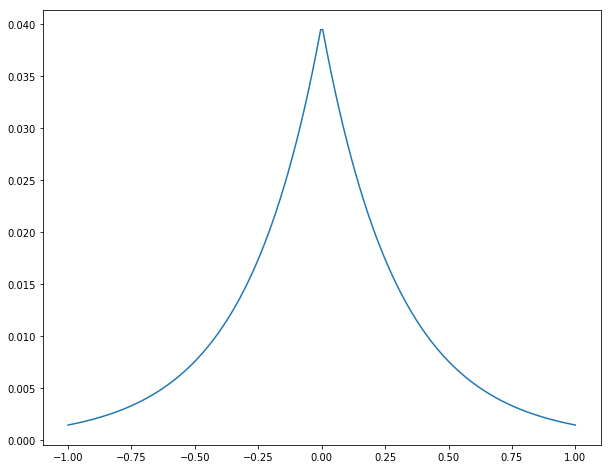

In [4]:
nx=250
xx = np.linspace(-1,1,nx)
plt.figure(figsize=(10,8))
plt.plot(xx,[k(x,0) for x in xx])

Now, suppose we wish to evaluate our function, $f(x)$, at various points $x_1, x_2, \ldots, x_N$. The GP framework says that these $N$ function values should be regarded as **a single sample from an $N$-dimensional Gaussian**. The mean of the Gaussian is determined from the mean function (which we have assumed to be zero), and the covariance matrix is constructed from the covariance function:

$$\mathbf{K} = \left(\begin{array}{cccc}k(x_1,x_1) & k(x_1,x_2)&\cdots&k(x_1,x_N)\\k(x_2,x_1)&k(x_2,x_2)&\cdots&k(x_2,x_N)\\\vdots&\vdots&\ddots&\vdots\\k(x_N,x_1)&k(x_N,x_2)&\cdots&k(x_N,x_N)\end{array}\right)$$

Let's start by assuming we are working with regularly-spaced points. We can plot the covariance matrix.

In [5]:
K = np.zeros([nx,nx])
for i in range(nx):
    for j in range(nx):
        K[i,j] = k(xx[i],xx[j])

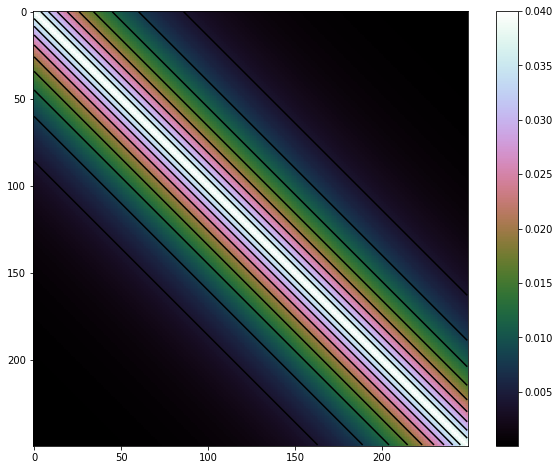

In [6]:
plt.figure(figsize=(10,8))
plt.imshow(K,cmap=plt.cm.cubehelix)
plt.colorbar()
plt.contour(K,10,colors='k')

We can also generate 10 random samples from this Gaussian, and plot them. Notice that all the wiggles have similar characteristics!

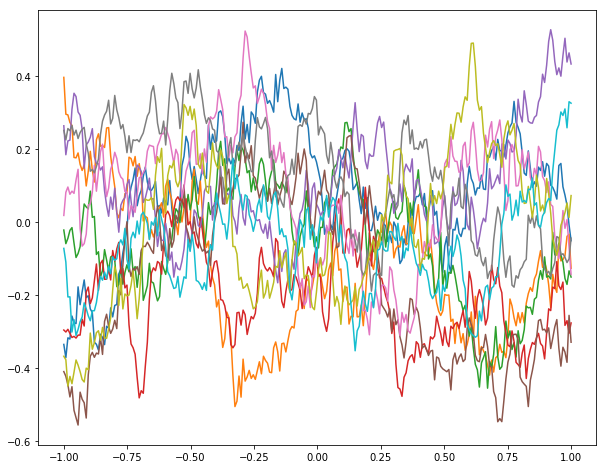

In [7]:
plt.figure(figsize=(10,8))
for i in range(0,10):
    plt.plot(xx,np.random.multivariate_normal(np.zeros(nx),K))

Where's the magic? The next step is to realise that we have a lot of mathematical results about Gaussian distributions. In particular, we know how to condition a multi-dimensional Gaussian on knowledge of *some* of its dimensions. Thus, if

$$\left(\begin{array}{c}f(x)\\f(\hat{x}_1)\\\vdots\\f(\hat{x}_N)\end{array}\right) \sim\mathcal{N}\left(\mathbf{0},\left(\begin{array}{cccc}k(x,x) & k(x,\hat{x}_1)&\cdots&k(x,\hat{x}_N)\\k(\hat{x}_1,x)&k(\hat{x}_1,\hat{x}_1)&\cdots&k(\hat{x}_1,\hat{x}_N)\\\vdots&\vdots&\ddots&\vdots\\k(\hat{x}_N,x)&k(\hat{x}_N,\hat{x}_1)&\cdots&k(\hat{x}_N,\hat{x}_N)\end{array}\right)\right)$$

then it follows that

$$
f(x)\,|\,\mathbf{\hat{y}}\sim \mathcal{N}\left(\left(\begin{array}{c}k(x,\hat{x}_1)\\\vdots\\k(x,\hat{x}_N)\end{array}\right)^\mathbf{T}\left(\begin{array}{ccc}k(\hat{x}_1,\hat{x}_1)&\cdots&k(\hat{x}_1,\hat{x}_N)\\\vdots&\ddots&\vdots\\k(\hat{x}_N,\hat{x}_1)&\cdots&k(\hat{x}_N,\hat{x}_N)\end{array}\right)^{-1}\left(\begin{array}{c}\hat{y}_1\\\vdots\\\hat{y}_N\end{array}\right), k(x,x) - \left(\begin{array}{c}k(x,\hat{x}_1)\\\vdots\\k(x,\hat{x}_N)\end{array}\right)^\mathbf{T}\left(\begin{array}{ccc}k(\hat{x}_1,\hat{x}_1)&\cdots&k(\hat{x}_1,\hat{x}_N)\\\vdots&\ddots&\vdots\\k(\hat{x}_N,\hat{x}_1)&\cdots&k(\hat{x}_N,\hat{x}_N)\end{array}\right)^{-1}\left(\begin{array}{c}k(x,\hat{x}_1)\\\vdots\\k(x,\hat{x}_N)\end{array}\right)\right)
$$

This is implemented in `scikit-learn`, but I can't get it to work(!) so let's just write it ourselves...

In [8]:
class gp(object):
    def __init__(self,mu,cov):
        self.mu = mu
        self.cov = cov
    def setObs(self,xObs,yObs,sigObs):
        self.xObs = xObs.copy()
        self.yObs = yObs.copy()
        self.sigObs = sigObs.copy()
        self.nObs = xObs.shape[0]
        self.computeK()
        self.computeMuVec()
    def computeK(self):
        self.K = np.zeros([self.nObs,self.nObs])
        for i in range(self.nObs):
            for j in range(self.nObs):
                self.K[i,j] = self.cov(self.xObs[i],self.xObs[j])
        self.K += np.diag(self.sigObs**2)
        self.invK = np.linalg.inv(self.K)
    def computeMuVec(self):
        self.muVec = np.zeros([self.nObs])
        for i in range(self.nObs):
            self.muVec[i] = self.mu(self.xObs[i])
    def kVec(self,x):
        kVec = np.zeros([self.nObs])
        for i in range(self.nObs):
            kVec[i] = self.cov(x,self.xObs[i])
        return kVec
    def __call__(self,x):
        kV = self.kVec(x)
        mean = self.mu(x) + kV.T.dot(self.invK).dot(self.yObs-self.muVec)
        std = self.cov(x,x)-kV.T.dot(self.invK).dot(kV)
        return mean,std
    def samplePath(self,xx,nsamples=1):
        npts = xx.shape[0]
        KV = np.zeros([self.nObs,npts])
        for i in range(npts):
            for j in range(self.nObs):
                KV[j,i] = self.cov(xx[i],self.xObs[j])
        muv = np.zeros(npts)
        for i in range(npts):
            muv[i] = self.mu(xx[i])
        mvMean = muv + KV.T.dot(self.invK).dot(self.yObs-self.muVec)
        mvCov = np.zeros([npts,npts])
        for i in range(npts):
            for j in range(npts):
                mvCov[i,j] = self.cov(xx[i],xx[j])
        mvCov-=KV.T.dot(self.invK).dot(KV)
        return np.random.multivariate_normal(mvMean,mvCov,size=nsamples)

Let's invent a few data points with error bars...

In [9]:
xObs = np.array([-0.5,-0.3,0.2,0.45])
yObs = np.array([0.1,-0.1,0.3,0.28])
sigObs = np.array([0.05,0.01,0.1,0.05])

(-1, 1)

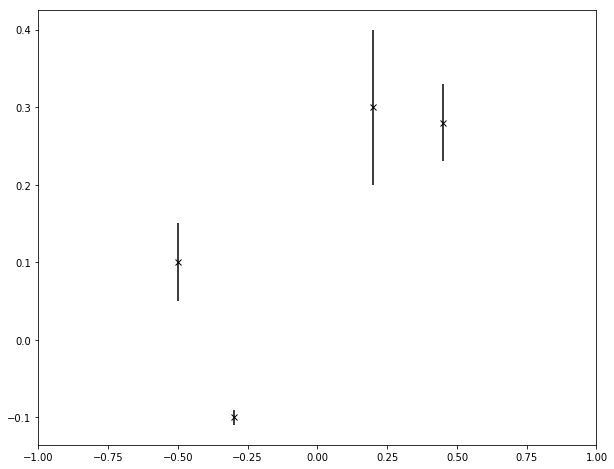

In [10]:
plt.figure(figsize=(10,8))
plt.errorbar(xObs,yObs,yerr=sigObs,fmt='xk')
plt.xlim(-1,1)

...and now fit a GP model...

In [11]:
g = gp(lambda x: 0,k)
g.setObs(xObs,yObs,sigObs)

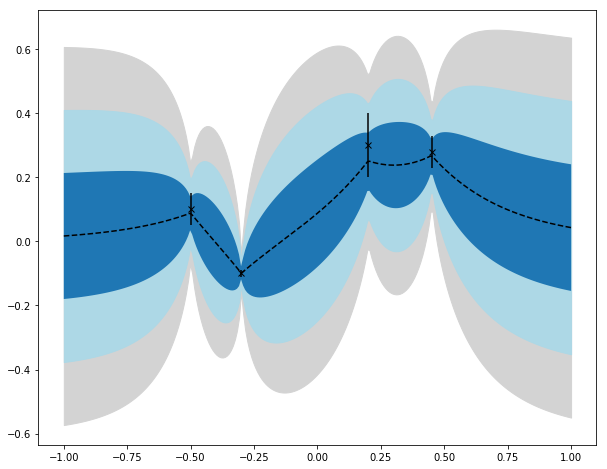

In [12]:
posteriorMean = np.zeros_like(xx)
posteriorStd = np.zeros_like(xx)
for i in range(xx.shape[0]):
    m,s=g(xx[i])
    posteriorMean[i] = m
    posteriorStd[i] = np.sqrt(s)
plt.figure(figsize=(10,8))
plt.fill_between(xx,posteriorMean+3*posteriorStd,posteriorMean-3*posteriorStd,color='lightGray')
plt.fill_between(xx,posteriorMean+2*posteriorStd,posteriorMean-2*posteriorStd,color='lightBlue')
plt.fill_between(xx,posteriorMean+posteriorStd,posteriorMean-posteriorStd)
plt.errorbar(xObs,yObs,yerr=sigObs,fmt='xk')
plt.plot(xx,posteriorMean,'k--')


We can draw random samples from this distribution...

<ErrorbarContainer object of 3 artists>

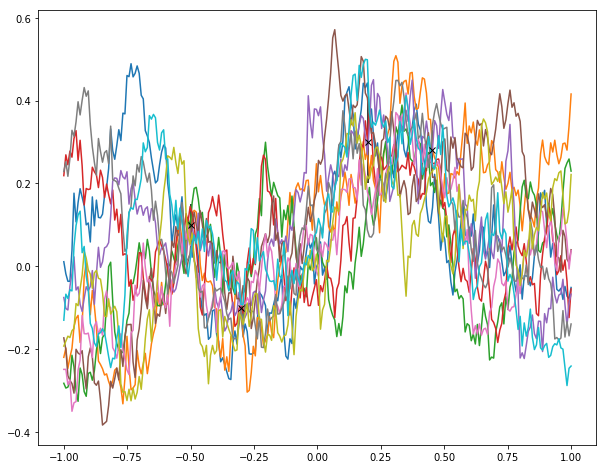

In [13]:
plt.figure(figsize=(10,8))
for v in g.samplePath(xx,10):
    plt.plot(xx,v)
plt.errorbar(xObs,yObs,yerr=sigObs,fmt='xk')

Linear transforms of a Gaussian Process are also Gaussian Processes. This allows us to integrate and differentiate.

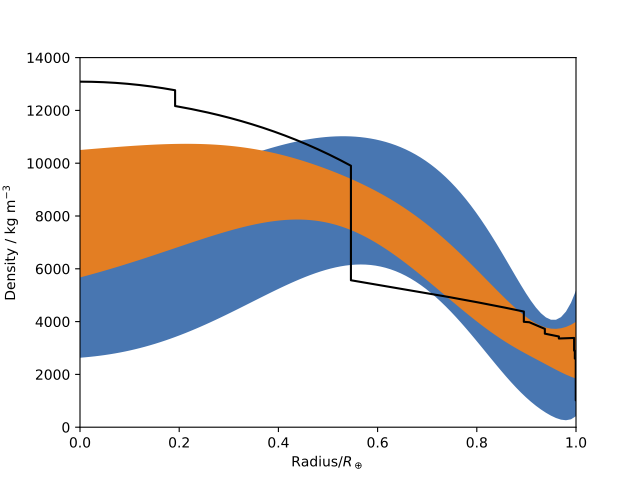

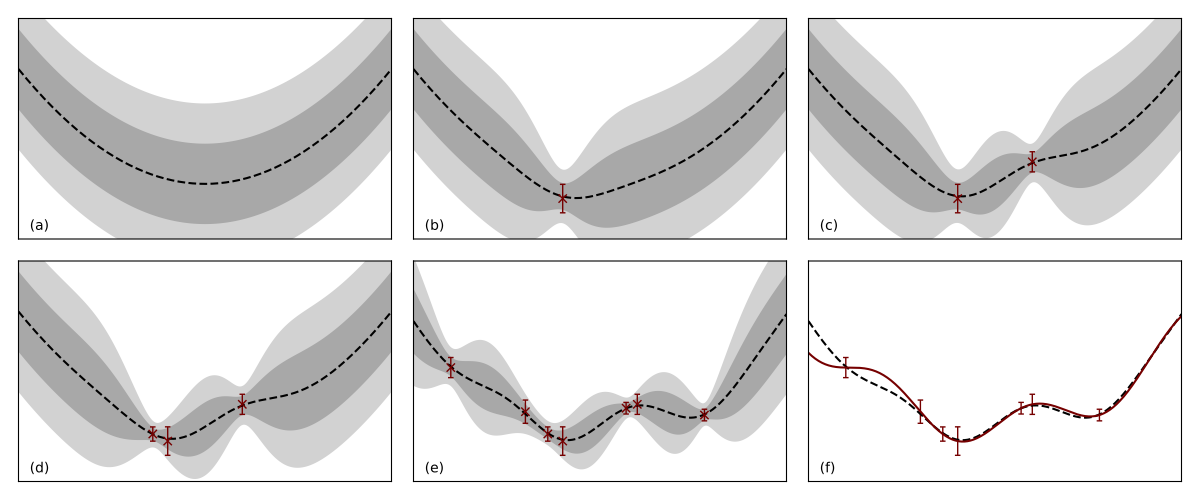

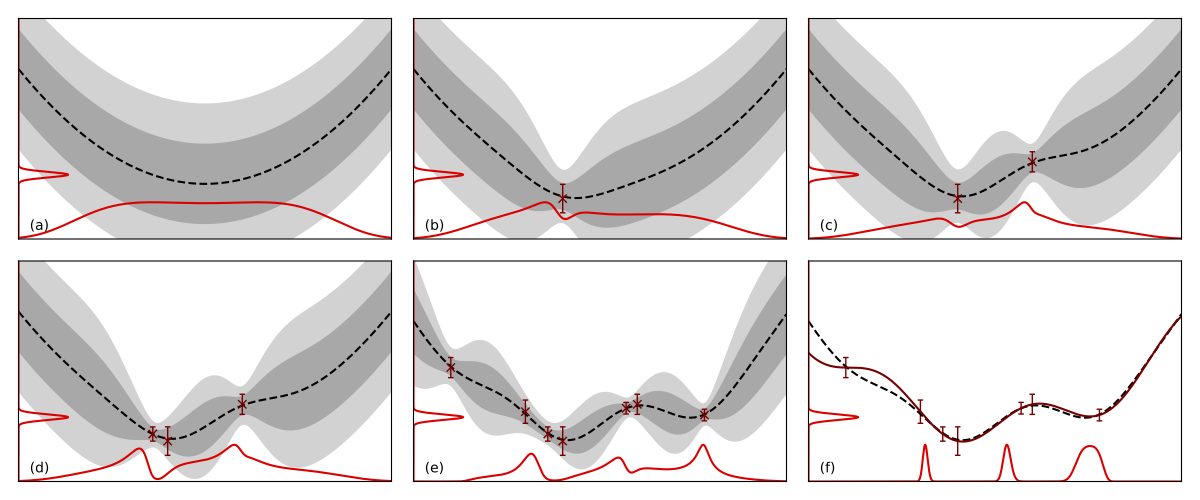